Company XYZ sells a software for 39. Since revenue has been ﬂat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price (39), while a random sample of 33% users a higher price (59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially he asked you the following questions:

* Should the company sell its software for 39 or 59?
* The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main ﬁndings looking at the data?
* **[ Bonus ]** The VP of Product feels that the test has been running for too long and he should have been able to get statistically signiﬁcant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

# Index
* [Load the data](#Load-the-data)
* [Check whether test/control group is randomly splitted?](#Check-whether-test-and-control-group-is-randomly-splitted?)
* [Answer question 1](#Answer-question-1)
* [Answer question 2](#Answer-question-2)
    * [Chi-Square test](#Chi-Square-test)
    * [How price affects conversion?](#How-price-affects-conversion?)
    * [How OS affects conversion?](#How-OS-affects-conversion?)
    * [Model by Decision Tree](#Model-by-Decision-Tree)
    * [**Actionable-Insights**](#Actionable-Insights)

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2,f_classif
from sklearn.tree import DecisionTreeClassifier,export_graphviz

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

seed = 999

## Load the data

In [4]:
testdata = pd.read_csv("test_results.csv",index_col="user_id")
# users contains [id,city,country,lat,long]
# and all 'country' column is USA
# I don't think users can provide useful information to the problems, so just ignore user_table.csv
# users = pd.read_csv("user_table.csv")

# some time has 60 seconds/minute, which cannot be processed by to_datetime
# if given more time, I will fix this incorrect format
# testdata["timestamp"] = pd.to_datetime(testdata.timestamp)

# rename to short names, make it easier to display
testdata.rename(columns={'operative_system':'OS'},inplace=True)

In [5]:
testdata.head()

,timestamp,source,device,OS,test,price,converted
user_id,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


## Check whether test and control group is randomly splitted?

In [6]:
X = testdata.copy()
del X['timestamp']

# to use sklearn to check feature importance, we must convert string values to numbers
src_label_encoder = LabelEncoder()
dev_label_encoder = LabelEncoder()
os_label_encoder = LabelEncoder()

X["source"] = src_label_encoder.fit_transform(testdata.source)
X["device"] = dev_label_encoder.fit_transform(testdata.device)
X["OS"] = os_label_encoder.fit_transform(testdata.OS)

In [7]:
X.head()

,source,device,OS,test,price,converted
user_id,,,,,,
604839,3,0,1,0,39,0
624057,8,0,0,0,39,0
317970,0,0,0,0,39,0
685636,5,0,1,1,59,0
820854,3,1,3,0,39,0


run ** Chi-Square test ** to see which factor impact the splitting between test/control group

In [8]:
colnames = ["source","device","OS"]
ch2values,pvalues = chi2(X.loc[:,colnames],X["test"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = colnames).sort_values(by='pvalue')

,chi2_value,pvalue
OS,83.085986,7.856065e-20
device,44.366335,2.723301e-11
source,0.924742,3.362329e-01


from above result, we know that the splitting between test/control groups aren't random. OS and device has great impact on the split.

In [9]:
def calc_ratios(s):
    d = s.value_counts(normalize=True)
    d['total'] = s.shape[0]
    return d
test_ctrl_by_os = testdata.groupby('OS')['test'].apply(calc_ratios).unstack()
test_ctrl_by_os

,0,1,total
OS,,,
android,0.643358,0.356642,74935.0
iOS,0.647934,0.352066,95465.0
linux,0.533736,0.466264,4135.0
mac,0.652422,0.347578,25085.0
other,0.647865,0.352135,16204.0
windows,0.629764,0.370236,100976.0


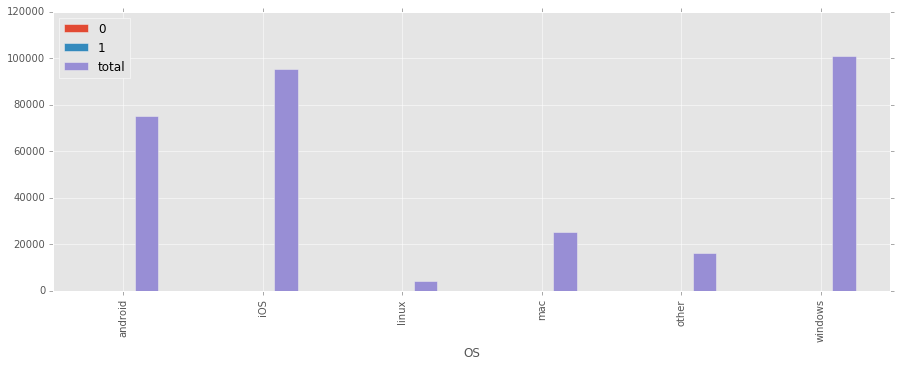

In [10]:
test_ctrl_by_os.plot(kind='bar',figsize=(15,5))

In [11]:
os_by_test_ctrl = testdata.groupby('test')['OS'].apply(lambda s: s.value_counts(normalize=True)).unstack()
os_by_test_ctrl 

,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313678,0.305115,0.237807,0.080729,0.051784,0.010887
1,0.327729,0.294636,0.234280,0.076434,0.050021,0.016901


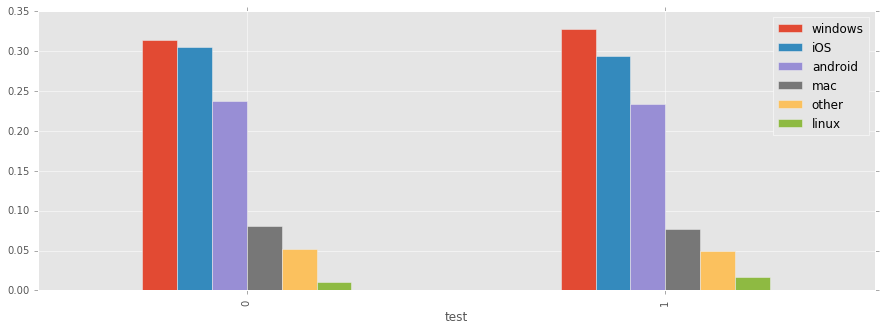

In [12]:
os_by_test_ctrl.plot(kind='bar',figsize=(15,5))

we can see that <span style='color:red;font-weight:bold'>OS distribution in test/control groups are very different</span>.

the experiment claim that '66% of the users have seen the old price (39), while a random sample of 33% users a higher price (59).', but <a id='linux_imbalance'></a><span style='color:red;font-weight:bold'>users from Linux don't obey such rule, but 53% go to control group, 47% go to test group</span>.

## Answer question 1
Should the company sell its software for 39 or 59?

In [13]:
revenues = testdata.groupby(by="test").apply(lambda df: df.price * df.converted)
ctrl_revenues = revenues[0]
test_revenues = revenues[1]

In [14]:
def group_statistics(df):
    return pd.Series({'n_users': df.shape[0],
                      'convert_rate': df.converted.mean(), 
                      'mean_revenue': (df.price * df.converted).mean()})
testdata.groupby('test').apply(group_statistics)

,convert_rate,mean_revenue,n_users
test,,,
0,0.019904,0.776734,202727.0
1,0.015543,0.916843,114073.0


we are going to perform a t-test to test whether the test group's average revenue is higher than control group's average revenue
* H0: test group's average revenue equal to control group's average revenue
* HA: test group's average revenue is higher than control group's average revenue

In [15]:
ttest_result = ss.ttest_ind(test_revenues,ctrl_revenues,equal_var=False)
# ttest_ind is a two tailed
# since our HA is test_mean > ctrl_mean, so we need to divide by 2
ttest_result.pvalue/2 

7.7037493023391909e-09

since the p-value is much smaller than 0.05 threshold, so we reject H0, and accept HA, that is, test group's average revenue is significantly higher than control group's average revenue.

but due to [OS distribution aren't the same between test/control groups](#linux_imbalance), price isn't the only difference between test/control groups, so we cannot contribute the increase in average revenue to price.

the experiment design fails, I cannot answer decide whether we can sell software to all users in 59 dollars. I suggest 
1. find the reason why linux users have different representation ratio than other OS.
2. then run the experiment again, make sure price is the only difference between test and control group
3. then run t-test again, to see whether the average revenue is significantly improved.
4. then I can draw the conclusion.

## Answer question 2
The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main ﬁndings looking at the data?

In [16]:
# X is the data after being transformed by LabelEncoder
X.tail()# glance the data

,source,device,OS,test,price,converted
user_id,,,,,,
17427,3,1,5,0,39,0
687787,5,1,5,0,39,0
618863,1,1,3,0,39,0
154636,6,0,0,0,39,0
832372,3,0,0,1,59,0


### Chi-Square test
I first run ** Chi-Square test ** to see which feature greatly impact converted or not

In [17]:
colnames = ["source","device","OS",'price']
ch2values,pvalues = chi2(X.loc[:,colnames],X["converted"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = colnames).sort_values(by='pvalue')

,chi2_value,pvalue
price,150.992849,1.051844e-34
OS,7.642955,5.699447e-03
source,2.373391,1.234187e-01
device,0.729490,3.930485e-01


Chi-Square test tells us, 
* <span style='color:orange;font-weight:bold;font-size:1.2em'>Price and OS are two main factor which impact converted or not</span>. 
* <span style='color:orange;font-weight:bold;font-size:1.2em'>Source and Device don't impact conversion rate that much.</span>

### How price affects conversion?

In [18]:
converted_by_price= testdata.groupby("price")['converted'].apply(lambda s: s.value_counts(normalize=True)).unstack()
converted_by_price

,0,1
price,,
39,0.980111,0.019889
59,0.984430,0.015570


<span style='color:orange;font-weight:bold;font-size:1.2em'>Users see 59 dollar has lower conversion rate than users see 39 dollars.</span>

### How OS affects conversion?

In [19]:
converted_by_os = testdata.groupby("OS")['converted'].apply(lambda s: s.value_counts(normalize=True)).unstack()
converted_by_os.sort_values(by=1,ascending=False)

,0,1
OS,,
mac,0.976002,0.023998
iOS,0.977678,0.022322
windows,0.983045,0.016955
android,0.985067,0.014933
other,0.987040,0.012960
linux,0.991778,0.008222


In [20]:
os_by_converted = testdata.groupby("converted")['OS'].apply(lambda s: s.value_counts(normalize=True)).unstack()
os_by_converted

,android,iOS,linux,mac,other,windows
converted,,,,,,
0,0.237357,0.300117,0.013187,0.078725,0.051429,0.319185
1,0.192665,0.366908,0.005854,0.103650,0.036157,0.294766


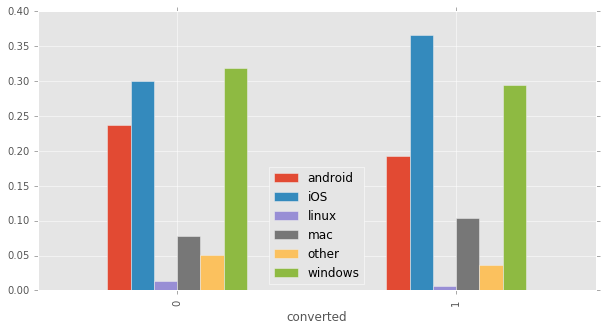

In [21]:
os_by_converted.plot(kind='bar',figsize=(10,5))

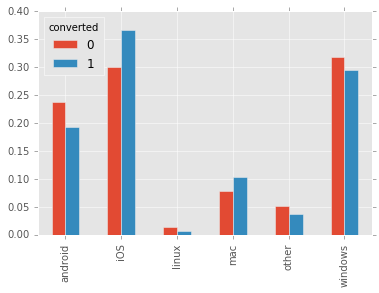

In [22]:
os_by_converted.transpose().plot(kind='bar')

from above result, we can see
* <span style='color:orange;font-size:1.5em'>Mac and iOS users have higher conversion rate than users from other OS.</span>
* <span style='color:orange;font-size:1.5em'>Linux users have lower conversion rate than users from other OS.</span>

### Model by Decision Tree
I will build a Decision Tree to get feature importance. Since the question is asking about "actionable insight" other than a model which precisely predict converted or not, so I will just fit a shallow Decision Tree on all the data, without giving out model's performance on test set.

In [23]:
testdata.sample(10)# glance the data

,timestamp,source,device,OS,test,price,converted
user_id,,,,,,,
840498,2015-03-23 19:22:17,seo-google,mobile,other,0,39,0
839879,2015-05-05 09:59:57,direct_traffic,mobile,iOS,1,59,0
468013,2015-03-29 23:52:11,direct_traffic,mobile,iOS,1,59,0
377372,2015-04-05 07:12:46,seo-google,mobile,android,1,59,0
713838,2015-03-10 13:53:46,seo-other,web,windows,0,39,0
140135,2015-03-08 10:12:03,ads_other,mobile,iOS,1,59,0
198679,2015-04-11 07:05:34,seo-google,web,windows,0,39,0
547268,2015-03-14 14:04:22,ads-google,mobile,iOS,0,39,0
334905,2015-05-28 10:14:47,ads-bing,web,mac,0,39,0


In [24]:
X = testdata.copy()
del X['timestamp']
del X['test']

In [25]:
X.source.value_counts()

direct_traffic     60357
ads-google         59379
ads_facebook       53396
ads_other          29876
seo-google         23175
ads-bing           22873
seo_facebook       21205
friend_referral    20695
seo-other           9260
ads-yahoo           7583
seo-yahoo           6848
seo-bing            2153
Name: source, dtype: int64

In [26]:
X.device.value_counts()

mobile    186471
web       130329
Name: device, dtype: int64

In [27]:
X.OS.value_counts()

windows    100976
iOS         95465
android     74935
mac         25085
other       16204
linux        4135
Name: OS, dtype: int64

In [28]:
# One-Hot-Encoding on categorical features
X = pd.get_dummies(X)

# a categorical feature of K unique values, only need K-1 vectors
# I don't use 'drop_first' parameter in get_dummies, since it cannot specify which level to drop
del X['source_ads_other']
del X['device_web']
del X['OS_other']

In [29]:
X.tail()# glance the data

,price,converted,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_mobile,OS_android,OS_iOS,OS_linux,OS_mac,OS_windows
user_id,,,,,,,,,,,,,,,,,,,
17427,39,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
687787,39,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
618863,39,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
154636,39,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
832372,59,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [30]:
Xtrain = X.loc[:,X.columns != 'converted']
ytrain = X.loc[:,'converted']

In [31]:
Xtrain.head()# glance the data

,price,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_mobile,OS_android,OS_iOS,OS_linux,OS_mac,OS_windows
user_id,,,,,,,,,,,,,,,,,,
604839,39,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
624057,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
317970,39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
685636,59,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
820854,39,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [36]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(Xtrain,ytrain)
export_graphviz(dt,feature_names=Xtrain.columns,proportion=True,leaves_parallel=True)

<img src='tree.png'></img>

from above tree plot, we can see that, to reach the leaf node with highest conversion rate (the third leaf from right with conversion rate=0.05), the path is:
1. source 'friend_referral' = true
2. price < 49, i.e., price = 39
3. OS 'iOS'= true

In [34]:
pd.Series(dt.feature_importances_,index = Xtrain.columns).sort_values(ascending=False)

source_friend_referral    0.663549
OS_iOS                    0.143231
OS_mac                    0.107014
source_ads-google         0.043922
price                     0.022918
OS_linux                  0.019366
source_ads-bing           0.000000
source_ads-yahoo          0.000000
source_ads_facebook       0.000000
source_direct_traffic     0.000000
OS_windows                0.000000
source_seo-bing           0.000000
source_seo-other          0.000000
source_seo-yahoo          0.000000
source_seo_facebook       0.000000
device_mobile             0.000000
OS_android                0.000000
source_seo-google         0.000000
dtype: float64

### Actionable Insights

* friend_referral, Apple user (MAC or iOS), low price are three great positive factors which improve the conversion rate
* if we want to increase the price, which impacts negatively on conversion rate, we must compensate on the other two factors
    * lauch special marketing program targeted to Apple users (MAC or iOS users)
    * run some program which rewards user which can invite his/her friend to use our software
* Linux users don't like our software as much as users on other OS. Development team should find out the reason. For example, is there any incompatibility issue on Linux?